# Setup

## Data Preprocessing Implementation

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

def data_preprocessing(country_data, treatment):
    data = country_data.drop(columns=['CNTRYID', 'CNT', 'CNTSTUID', 
                                      'preprimary_start_theo', 'primary_start_theo']).copy()
    treatment = country_data[treatment]
    outcome = data['PV1READ']
    categorial_properties = ['ST003D02T','ST003D03T', 'STRATUM','LANGTEST_QQQ', 'IMMIG', 'ST001D01T',
                             'ST004D01T', 'ST013Q01TA', 'MISCED', 'FISCED',
                             'ST126Q01TA','ST022Q01TA', 'ST023Q01TA', 'ST023Q02TA', "OCOD1", "OCOD2", 
                            ]
    numerical_properties = ["ST021Q01TA", "BMMJ1", "BFMJ2", "ESCS", "WEALTH"]
    
    numerical_covariates = data[numerical_properties]
    categorial_covariates = data[categorial_properties]
    
    # scaling numerical properties
    scaler = preprocessing.MinMaxScaler()
    scaler.fit(numerical_covariates)
    x_scaled = scaler.transform(numerical_covariates)
    
    # encoding categorial covariates
    ohe = preprocessing.OneHotEncoder()
    ohe.fit(categorial_covariates)
    categorial_encoding = ohe.transform(categorial_covariates).toarray()
    
    #remove dependent categorial columns
    variables_in_category = [data[col].nunique() for col in categorial_properties]
    columns_to_remove = [variables_in_category[0]-1]
    for i in range(1, len(variables_in_category)):
        columns_to_remove.append(variables_in_category[i] + columns_to_remove[i-1])
    categorial_encoding = np.delete(categorial_encoding, columns_to_remove, 1)
    
    X = np.concatenate([x_scaled, categorial_encoding], axis=1)

    return X, treatment, outcome

## Propensity score estimation and analysis tools implementation

In [2]:
def estimate_propensity(X, treatment):
    # Learn propensity score
    lr_learner = LogisticRegression(C=10, solver='lbfgs', max_iter=10000)
    lr_learner.fit(X, treatment)
    propensity_score = lr_learner.predict_proba(X)[:, 1]   
    return propensity_score


def trim_common_support(X, treated_propensity_score, control_propensity_score, propensity_scores, treatment, outcome):
    """
    Trim data that does not appear to maintain common support, using min max approach on propensity core
    """
    min_treated = np.min(treated_propensity_score)
    max_treated = np.max(treated_propensity_score)
    min_control = np.min(control_propensity_score)
    max_control = np.max(control_propensity_score)
    max_min = np.maximum(min_control, min_treated)
    min_max = np.minimum(max_control, max_treated)

    indices_smaller_than_max_min = np.argwhere(propensity_scores < max_min)
    indices_greater_than_min_max = np.argwhere(propensity_scores > min_max)
    rows_to_delete = np.concatenate([indices_greater_than_min_max, indices_smaller_than_max_min])
    rows_to_delete = rows_to_delete.reshape((-1,))
    exclude_idx = set(rows_to_delete)
    mask = np.array([(i in exclude_idx) for i in range(len(X))])

    return X[~mask], propensity_scores[~mask], treatment[~mask], outcome[~mask]


def plot_overlap_histograms(treated_propensity_score, 
                            control_propensity_score, logscale=False):
    fig, ax = plt.subplots()
    ax.hist(treated_propensity_score, bins=20, color="crimson", alpha=0.5, label="treated",
            ec='black', log=logscale)
    ax.hist(control_propensity_score, bins=20, color="teal", alpha=0.6, label="control", 
            ec='blue', log=logscale)
    scale = "(logarithmic scale)" if logscale else ""
    ax.set(xlabel="propensity score", title="Propensity Score Histogram {}".format(scale))
    plt.legend()
    plt.show()
    
    
def plot_calibration(propensity_score, bins, treatment, ax=None):
    treated_avg = []
    propensity_avg = []
    limit_low = min(propensity_score)
    for i in range(bins):
        treatment_in_range = treatment[(propensity_score>= i/bins) & (propensity_score< (i+1)/bins)]
        propensity_in_range = propensity_score[(propensity_score>= i/bins) & (propensity_score< (i+1)/bins)]
        if treatment_in_range.shape[0]:
            treated_avg.append((treatment_in_range == 1).sum()/treatment_in_range.shape[0])
            propensity_avg.append(propensity_in_range.sum()/propensity_in_range.shape[0])
    
    if ax==None:
        ax = plt.gca()
    ax.plot(propensity_avg, treated_avg, label = 'treated average', color='r')
    ax.plot(np.array(range(bins))/bins, np.array(range(bins))/bins, 'k--', label='RCT')
    ax.legend()
    ax.set(xlabel='Probability of Treatment', ylabel='Treated Average in bin', title='Calibration Graph')
    
def sample_size_table(original_treatment, trimmed_treatment):
    all_population = [len(original_treatment), len(trimmed_treatment)]
    treated = [original_treatment.sum(), trimmed_treatment.sum()]
    control = [(1-original_treatment).sum(), (1-trimmed_treatment).sum()]
    return pd.DataFrame([all_population, treated, control], 
                        index=['Sample size', 'Treated group size', 'Control group size'], 
                       columns=['Before trimming', 'After trimming'])

In [3]:
# load data
data = pd.read_csv("all_confounders.csv")
data = data[data["DURECEC"]<7].copy()
data["Treatment 1"] = (data["DURECEC"] > 0).astype(int)
data["Treatment 2"] = (data["DURECEC"] > 1).astype(int)

# Canada Analysis
All figures below demonstrate the overlap between the treated and the control groups <b>before</b> the trimming of the data. 

## Treatment 1

In [4]:
country = data[(data["CNT"] == "CAN") & (data["LANGTEST_QQQ"]==313)].copy()
X, original_treatment, outcome = data_preprocessing(country, "Treatment 1")
original_propensity = estimate_propensity(X, original_treatment)
treated_propensity_score = original_propensity[original_treatment == 1]
control_propensity_score = original_propensity[original_treatment == 0]
X, propensity, treatment, outcome = trim_common_support(X, treated_propensity_score, 
                                                        control_propensity_score, original_propensity, 
                                                        original_treatment, outcome)
sample_size_table(original_treatment, treatment)

,Before trimming,After trimming
Sample size,8866,8060
Treated group size,7909,7104
Control group size,957,956


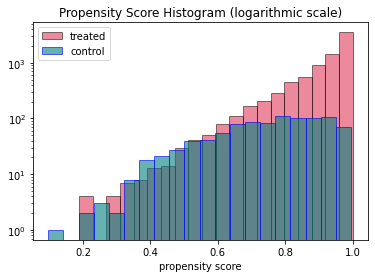

In [5]:
plot_overlap_histograms(treated_propensity_score, control_propensity_score, logscale=True)

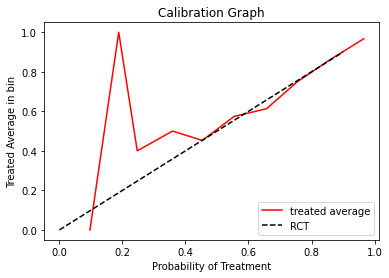

In [6]:
plot_calibration(original_propensity, 10, original_treatment)

## Treatment 2

In [7]:
country = data[(data["CNT"] == "CAN") & (data["LANGTEST_QQQ"]==313)].copy()
X, original_treatment, outcome = data_preprocessing(country, "Treatment 2")
original_propensity = estimate_propensity(X, original_treatment)
treated_propensity_score = original_propensity[original_treatment == 1]
control_propensity_score = original_propensity[original_treatment == 0]
X, propensity, treatment, outcome = trim_common_support(X, treated_propensity_score, 
                                                        control_propensity_score, original_propensity, 
                                                        original_treatment, outcome)
sample_size_table(original_treatment, treatment)

,Before trimming,After trimming
Sample size,8866,8668
Treated group size,4145,3974
Control group size,4721,4694


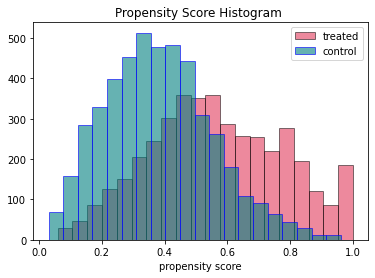

In [8]:
plot_overlap_histograms(treated_propensity_score, control_propensity_score)

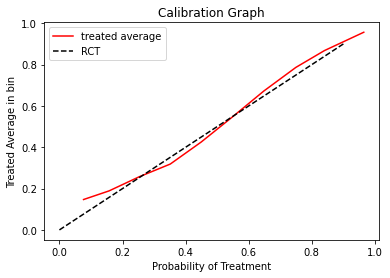

In [9]:
plot_calibration(original_propensity, 10, original_treatment)

# Australia Analysis (Treatment 2 only)

In [10]:
country = data[(data["CNT"] == "AUS")].copy()
X, original_treatment, outcome = data_preprocessing(country, "Treatment 2")
original_propensity = estimate_propensity(X, original_treatment)
treated_propensity_score = original_propensity[original_treatment == 1]
control_propensity_score = original_propensity[original_treatment == 0]
X, propensity, treatment, outcome = trim_common_support(X, treated_propensity_score, 
                                                        control_propensity_score, original_propensity, 
                                                        original_treatment, outcome)
sample_size_table(original_treatment, treatment)

,Before trimming,After trimming
Sample size,7681,7515
Treated group size,4020,3867
Control group size,3661,3648


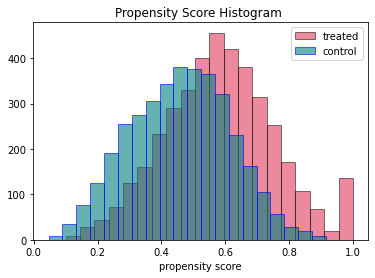

In [11]:
plot_overlap_histograms(treated_propensity_score, control_propensity_score)

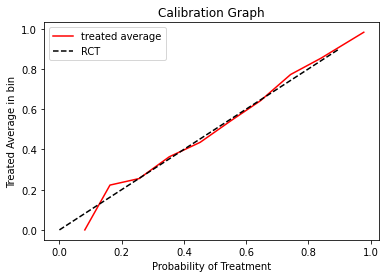

In [12]:
plot_calibration(original_propensity, 10, original_treatment)

# Ireland Analysis (Treatment 2 only)

In [13]:
country = data[(data["CNT"] == "IRL") &(data["LANGTEST_QQQ"]==313)].copy()
X, original_treatment, outcome = data_preprocessing(country, "Treatment 2")
original_propensity = estimate_propensity(X, original_treatment)
treated_propensity_score = original_propensity[original_treatment == 1]
control_propensity_score = original_propensity[original_treatment == 0]
X, propensity, treatment, outcome = trim_common_support(X, treated_propensity_score, 
                                                        control_propensity_score, original_propensity, 
                                                        original_treatment, outcome)
sample_size_table(original_treatment, treatment)

,Before trimming,After trimming
Sample size,3228,3154
Treated group size,1877,1816
Control group size,1351,1338


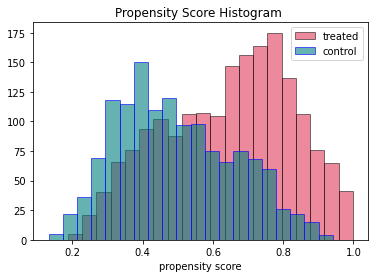

In [14]:
plot_overlap_histograms(treated_propensity_score, control_propensity_score)

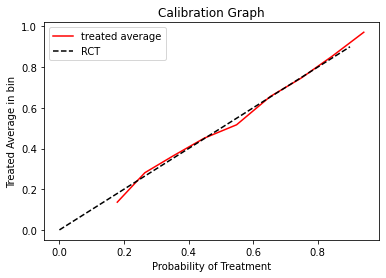

In [15]:
plot_calibration(original_propensity, 10, original_treatment)